In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Materials science libraries
from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty
from pymatgen.core.composition import Composition
import smact  # For valence electron calculations

# SHAP library
import shap

# Other imports
import csv
import re
from math import sqrt
from typing import Dict

# Set up matplotlib parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


/home/ryan/.conda/envs/ml-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function Definitions

In [2]:
def valence_electron_count(compound: str) -> float:
    """
    Calculate the Valence Electron Count (VEC) for a given chemical compound.
    """
    def get_element_valence(element: str) -> int:
        try:
            return smact.Element(element).num_valence_modified
        except Exception:
            raise ValueError(f"Valence data not found for element: {element}")
    
    element_stoich = Composition(compound).get_el_amt_dict()
    total_valence = total_stoich = 0
    for element, stoich in element_stoich.items():
        valence = get_element_valence(element)
        total_valence += stoich * valence
        total_stoich += stoich
    return total_valence / total_stoich if total_stoich != 0 else 0.0

def load_element_data(filename: str) -> Dict[str, float]:
    """
    Load element data from a CSV file.
    """
    element_data = {}
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            element = row["element"]
            electronegativity = float(row["Electronegativity"])
            element_data[element] = electronegativity
    return element_data

def parse_formula(formula: str) -> Dict[str, float]:
    """
    Parse a chemical formula into its elements and their stoichiometries.
    """
    pattern = re.compile(r"([A-Z][a-z]*)(\d*\.?\d*)")
    elements = pattern.findall(formula)
    return {elem: float(count) if count else 1.0 for elem, count in elements}

def calculate_atomic_concentrations(formula: str) -> Dict[str, float]:
    """
    Calculate atomic concentrations of elements in a formula.
    """
    parsed_formula = parse_formula(formula)
    total_atoms = sum(parsed_formula.values())
    return {elem: count / total_atoms for elem, count in parsed_formula.items()}

def calculate_electronegativity_difference(formula: str, element_data: Dict[str, float]) -> float:
    """
    Calculate the electronegativity difference in a compound.
    """
    concentrations = calculate_atomic_concentrations(formula)
    avg_electronegativity = sum(
        concentrations[elem] * element_data.get(elem, 0) for elem in concentrations
    )
    diff_sum = sum(
        concentrations[elem] * (element_data.get(elem, 0) - avg_electronegativity) ** 2
        for elem in concentrations
    )
    return sqrt(diff_sum)


# Data loading and feature extraction

In [3]:
# Load the dataset
df = load_dataset("matbench_expt_gap")
print(f"Dataset loaded with {len(df)} entries.")

# Define Magpie features and stats
features = [
    'Number', 'MendeleevNumber', 'AtomicWeight', 'CovalentRadius', 'Electronegativity', 
    'NsValence', 'NpValence', 'NdValence', 'NfValence', 'NValence', 
    'NsUnfilled', 'NpUnfilled', 'NdUnfilled', 'NfUnfilled', 'NUnfilled', 
    'GSvolume_pa', 'GSbandgap', 'GSmagmom', 'SpaceGroupNumber'
]
stats = ['minimum', 'maximum', 'mean', 'range', 'std_dev']

# Initialize the featurizer
featurizer = ElementProperty(data_source='magpie', features=features, stats=stats)

# Featurize the data
df["composition"] = df["composition"].apply(Composition)
df_features = featurizer.featurize_dataframe(df, col_id='composition', ignore_errors=True)
feature_labels = featurizer.feature_labels()

# Calculate VEC
df['VEC'] = df['composition'].apply(lambda x: valence_electron_count(x.formula))

# Load element data and calculate Electronegativity Difference
element_data = load_element_data("magpiery.csv")  # Ensure this file contains 'element' and 'Electronegativity' columns
df['ElectronegativityDifference'] = df['composition'].apply(
    lambda x: calculate_electronegativity_difference(x.formula, element_data)
)

# Combine features
df_combined = pd.concat([df_features, df[['VEC', 'ElectronegativityDifference']]], axis=1)

# Prepare target variable
df['is_metal'] = (df['gap expt'] == 0.0).astype(int)
y = df['is_metal'].values


/home/ryan/.conda/envs/ml-env/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


Dataset loaded with 4604 entries.


ElementProperty: 100%|██████████| 4604/4604 [00:02<00:00, 1964.44it/s]



# Feature matrix preparation and GridSearchCV hyperparameter tuning

In [4]:

# 9. Prepare feature matrix
X = df_combined

# Remove the 'composition' and 'gap expt' columns if they exist
columns_to_drop = ['composition', 'gap expt']
X = X.drop(columns=[col for col in columns_to_drop if col in X.columns], axis=1)

# Handle missing values if any
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# 11. Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 5]
}

# 12. Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# 13. Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-metal', 'Metal']))


Best hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
Test Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.91      0.96      0.93       431
       Metal       0.96      0.91      0.94       490

    accuracy                           0.93       921
   macro avg       0.93      0.94      0.93       921
weighted avg       0.94      0.93      0.93       921




# Plot confusion matrix


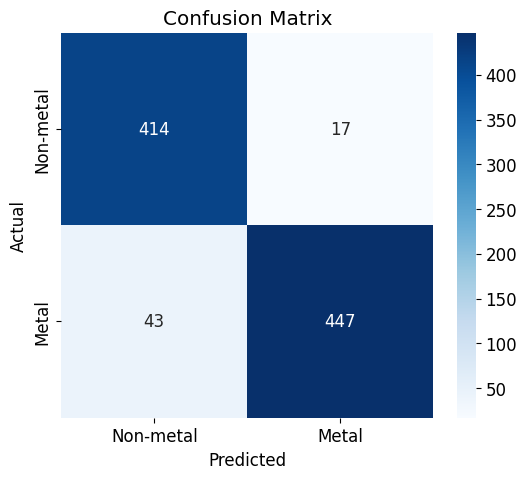

In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Non-metal', 'Metal'], yticklabels=['Non-metal', 'Metal']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
# Extract false positives and false negatives
y_pred_series = pd.Series(y_pred, index=X_test.index)
y_test_series = pd.Series(y_test, index=X_test.index)

# Get original composition and gap data
composition_data = X_test[['composition']] if 'composition' in X_test.columns else None
gap_data = X_test[['gap_expt']] if 'gap_expt' in X_test.columns else None

# False positives: Predicted metal but actually non-metal
false_positives = X_test[(y_pred_series == 1) & (y_test_series == 0)]
# False negatives: Predicted non-metal but actually metal  
false_negatives = X_test[(y_pred_series == 0) & (y_test_series == 1)]

# Add composition and gap columns if they exist
if composition_data is not None:
    false_positives = pd.concat([false_positives, composition_data.loc[false_positives.index]], axis=1)
    false_negatives = pd.concat([false_negatives, composition_data.loc[false_negatives.index]], axis=1)
if gap_data is not None:
    false_positives = pd.concat([false_positives, gap_data.loc[false_positives.index]], axis=1)
    false_negatives = pd.concat([false_negatives, gap_data.loc[false_negatives.index]], axis=1)

# Save to CSV files
false_positives.to_csv('false_positives_predicted_metals.csv')
false_negatives.to_csv('false_negatives_predicted_nonmetals.csv')

print(f"Number of false positives (predicted metal, actually non-metal): {len(false_positives)}")
print(f"Number of false negatives (predicted non-metal, actually metal): {len(false_negatives)}")


Number of false positives (predicted metal, actually non-metal): 17
Number of false negatives (predicted non-metal, actually metal): 43




# SHAP feature analysis


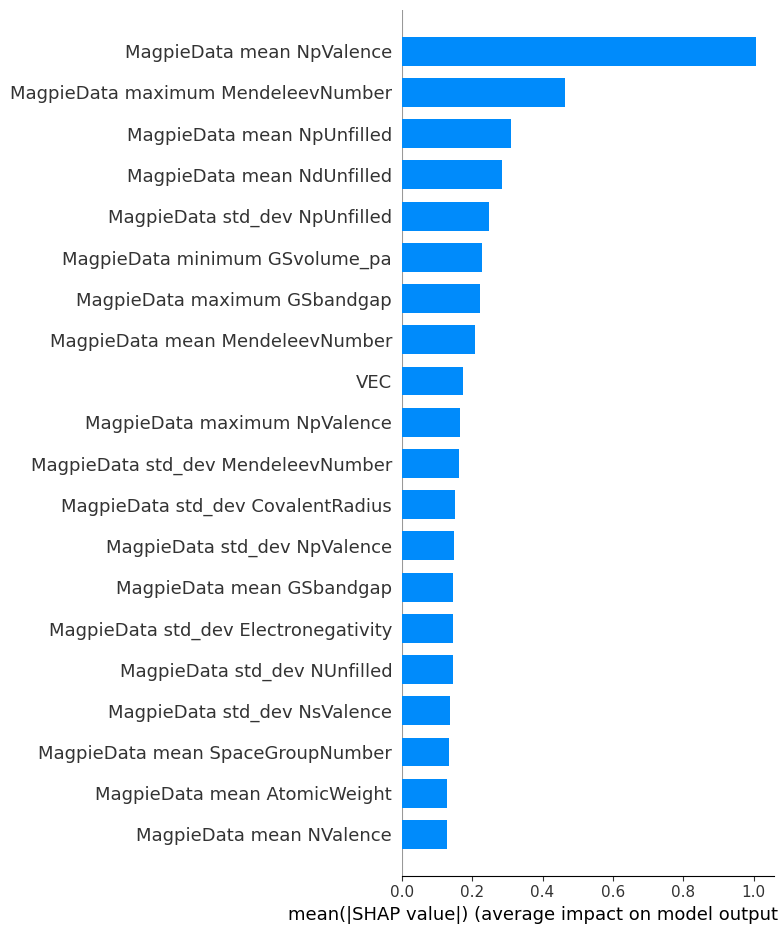

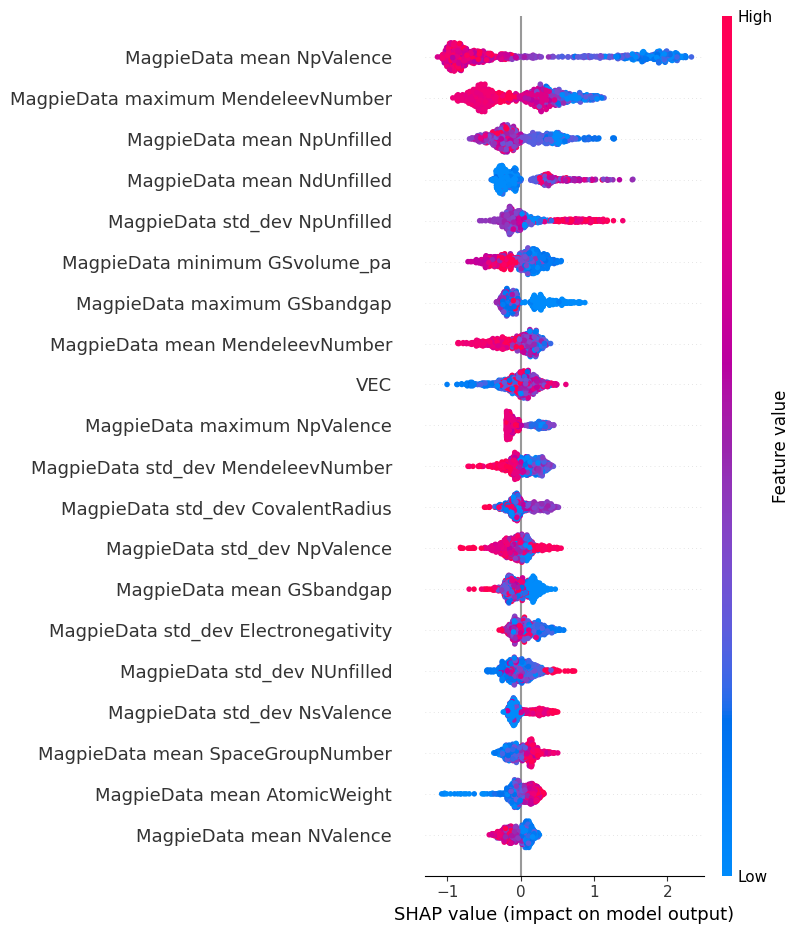

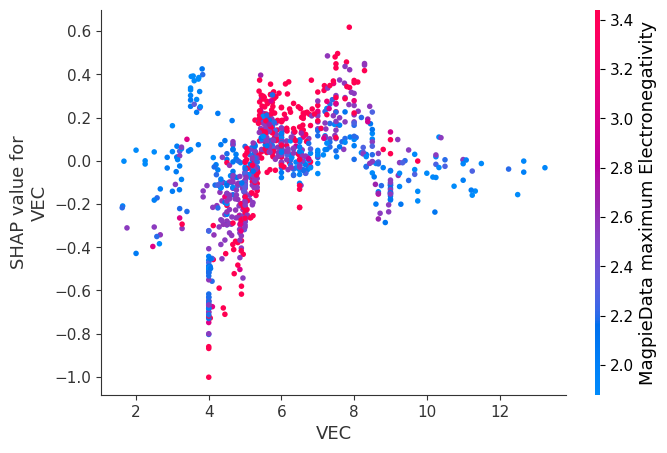


VEC SHAP Importance: 0.1743
Electronegativity Difference SHAP Importance: 0.0715


In [6]:

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type='bar')

# Plot SHAP values for top features
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Plot SHAP dependence plot for 'VEC'
shap.dependence_plot('VEC', shap_values, X_test, feature_names=X.columns)

# 20. Assessing VEC and Electronegativity Difference Importance
shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': shap_importance
}).sort_values(by='Importance', ascending=False)

vec_importance = importance_df[importance_df['Feature'] == 'VEC']['Importance'].values[0]
en_diff_importance = importance_df[importance_df['Feature'] == 'ElectronegativityDifference']['Importance'].values[0]

print(f"\nVEC SHAP Importance: {vec_importance:.4f}")
print(f"Electronegativity Difference SHAP Importance: {en_diff_importance:.4f}")


# Plot histograms for top 20 features


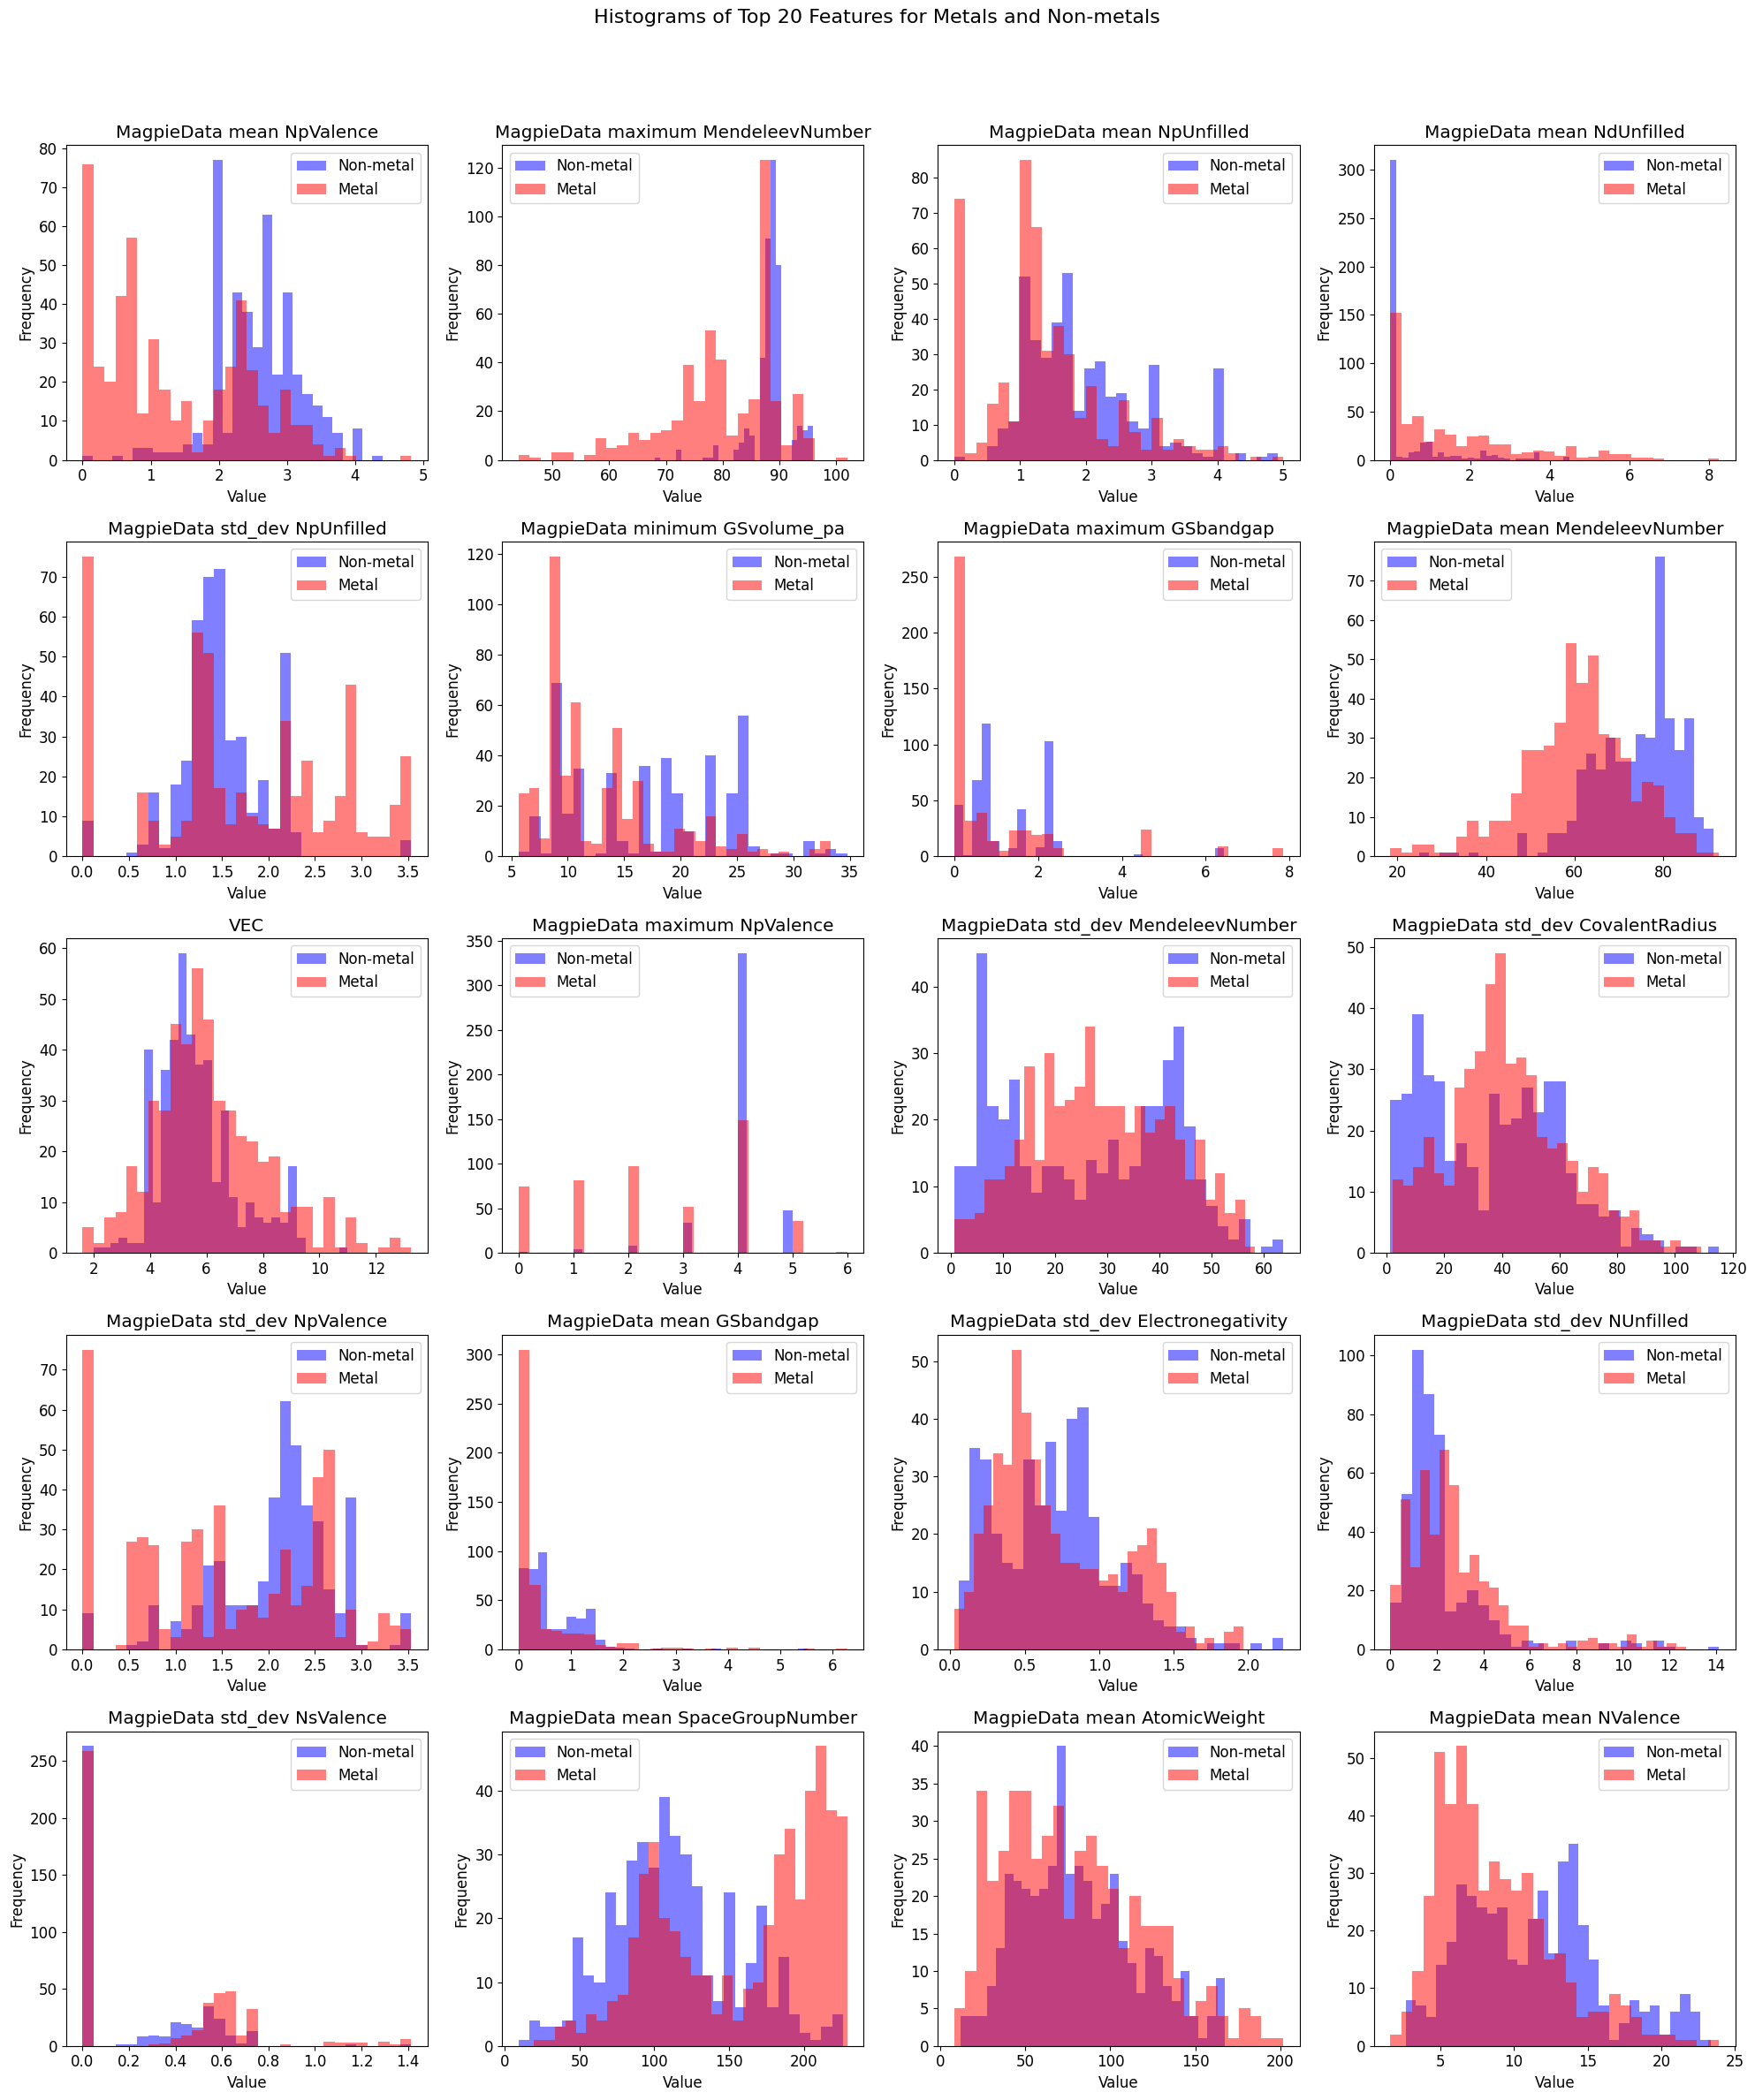

Top 20 Features:
           MagpieData mean NpValence
  MagpieData maximum MendeleevNumber
          MagpieData mean NpUnfilled
          MagpieData mean NdUnfilled
       MagpieData std_dev NpUnfilled
      MagpieData minimum GSvolume_pa
        MagpieData maximum GSbandgap
     MagpieData mean MendeleevNumber
                                 VEC
        MagpieData maximum NpValence
  MagpieData std_dev MendeleevNumber
   MagpieData std_dev CovalentRadius
        MagpieData std_dev NpValence
           MagpieData mean GSbandgap
MagpieData std_dev Electronegativity
        MagpieData std_dev NUnfilled
        MagpieData std_dev NsValence
    MagpieData mean SpaceGroupNumber
        MagpieData mean AtomicWeight
            MagpieData mean NValence


In [7]:


# Get the top 20 most important features
top_20_features = importance_df['Feature'].head(20).tolist()

# Create a figure with subplots
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
fig.suptitle('Histograms of Top 20 Features for Metals and Non-metals', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, feature in enumerate(top_20_features):
    # Plot histogram for non-metals
    axes[i].hist(X_test[y_test == 0][feature], bins=30, alpha=0.5, label='Non-metal', color='blue')
    # Plot histogram for metals
    axes[i].hist(X_test[y_test == 1][feature], bins=30, alpha=0.5, label='Metal', color='red')
    
    axes[i].set_title(feature)
    axes[i].legend()
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print the top 20 features
print("Top 20 Features:")
print(importance_df['Feature'].head(20).to_string(index=False))


# Create pairplots for selected features


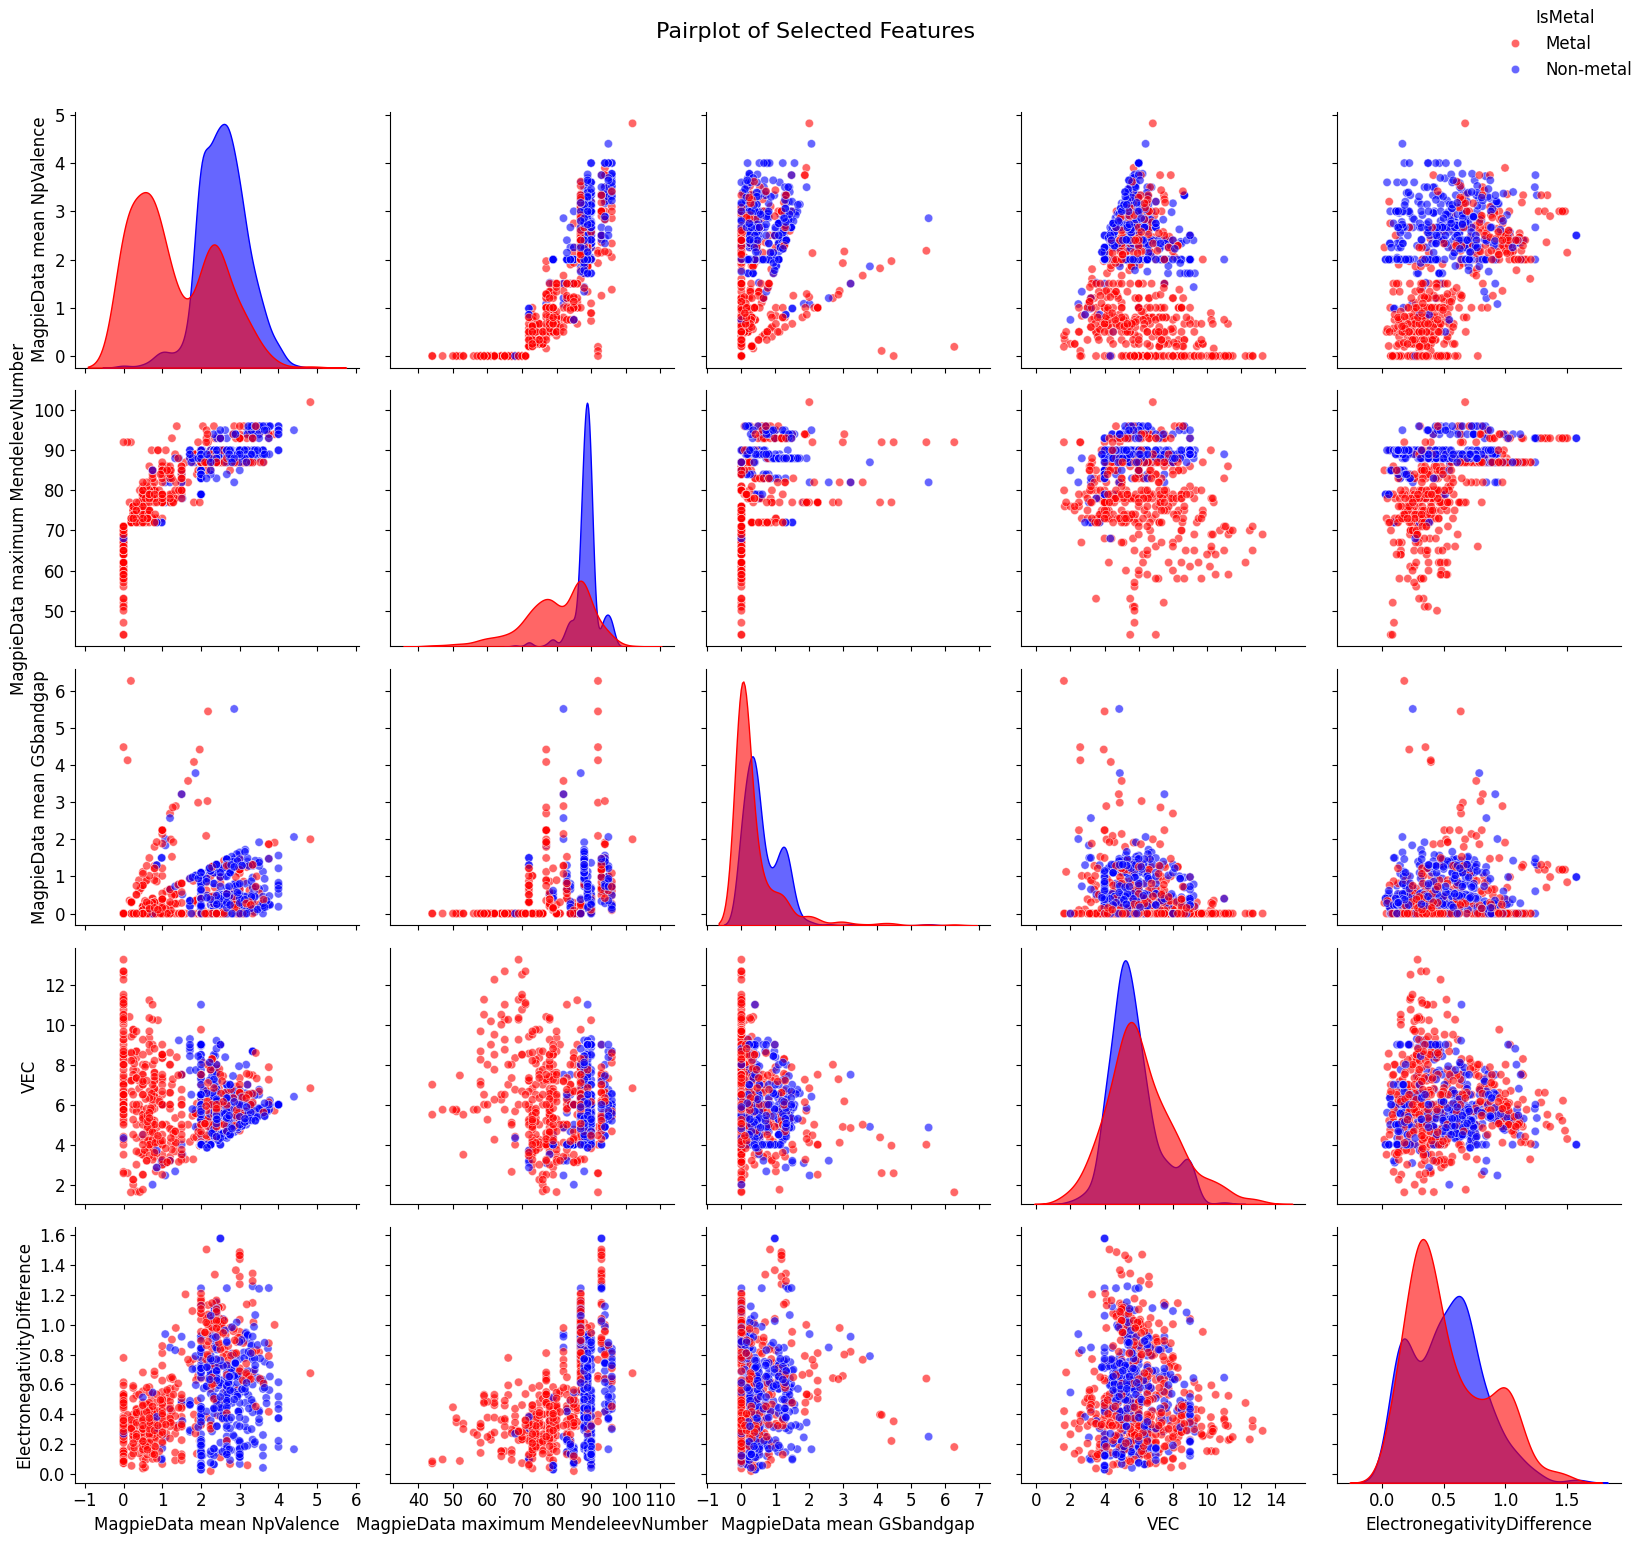

In [8]:


import seaborn as sns

# Adjusted feature names based on actual column names
selected_features = [
    'MagpieData mean NpValence',          # Mean NpValence
    'MagpieData maximum MendeleevNumber', # Max MendeleevNumber
    'MagpieData mean GSbandgap',          # Mean GSbandgap
    'VEC',                     # VEC
    'ElectronegativityDifference'  # Electronegativity Difference
]

# Check if selected features are in X_test
missing_features = [f for f in selected_features if f not in X_test.columns]
if missing_features:
    print(f"The following features are missing in X_test: {missing_features}")

# Create a new dataframe with selected features and the target variable
plot_df = X_test[selected_features].copy()
plot_df['IsMetal'] = y_test

# Map the target variable to labels
plot_df['IsMetal'] = plot_df['IsMetal'].map({0: 'Non-metal', 1: 'Metal'})

# Set up the pairplot
pairplot = sns.pairplot(
    plot_df,
    hue='IsMetal',
    vars=selected_features,
    plot_kws={'alpha': 0.6},
    diag_kws={'alpha': 0.6},
    palette={'Non-metal': 'blue', 'Metal': 'red'},
    height=3,  # Reduce the size of each subplot
    aspect=1,  # Keep the aspect ratio square
)

# Affix the legend to the top right
pairplot._legend.set_bbox_to_anchor((1, 1))

# Reduce font size for x and y labels
plt.rcParams.update({'axes.labelsize': 8})
plt.rcParams.update({'xtick.labelsize': 6})
plt.rcParams.update({'ytick.labelsize': 6})

plt.suptitle('Pairplot of Selected Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


# KDE Plot for VEC vs Electronegativity Difference


/home/ryan/.conda/envs/ml-env/lib/python3.11/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


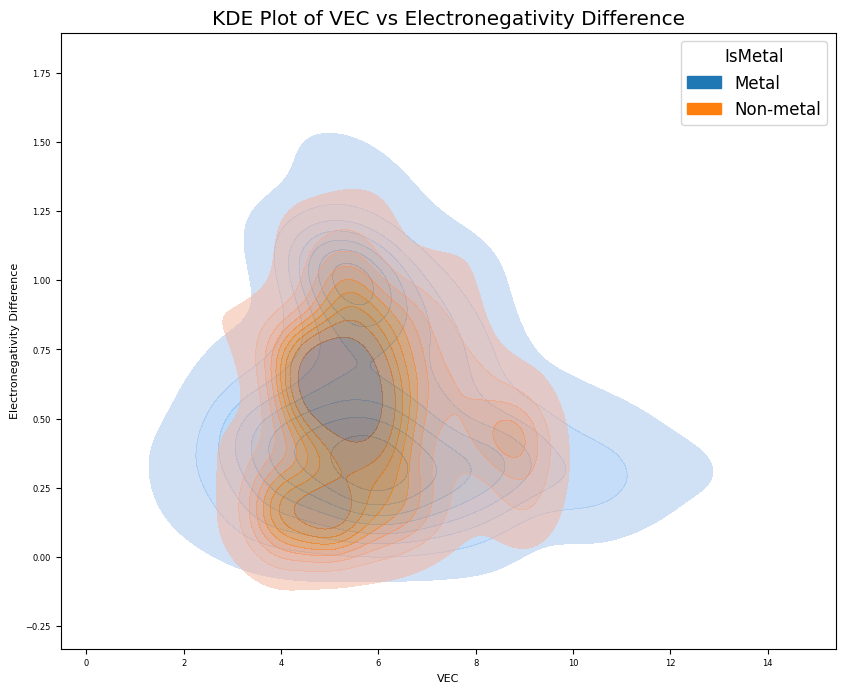

In [9]:

plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=plot_df,
    x='VEC', y='ElectronegativityDifference',
    hue='IsMetal', fill=True,
    cmap='coolwarm', alpha=0.5
)
plt.xlabel('VEC')
plt.ylabel('Electronegativity Difference')
plt.title('KDE Plot of VEC vs Electronegativity Difference')
plt.show()


# Plotting 2D histogram of VEC vs Electronegativity Difference


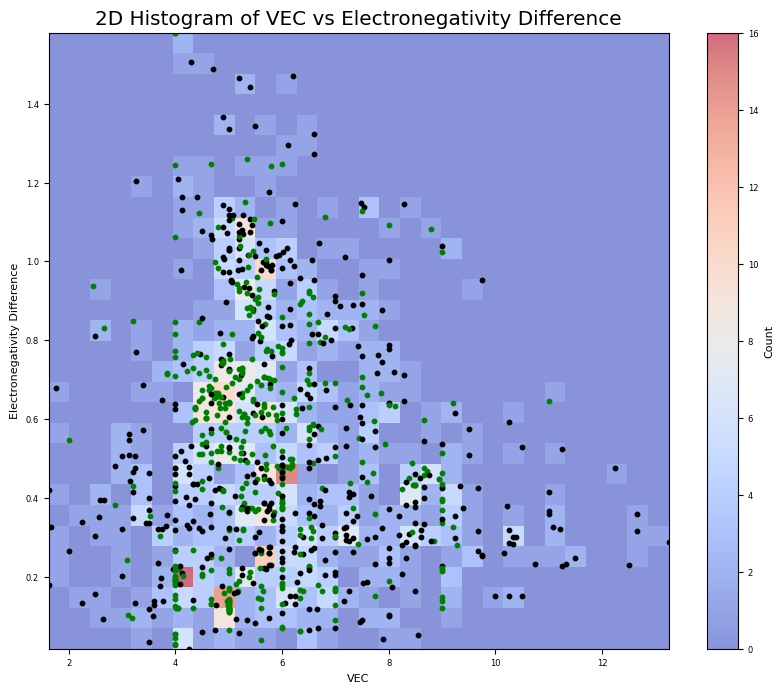

In [10]:

plt.figure(figsize=(10, 8))
plt.hist2d(
    X_test['VEC'], X_test['ElectronegativityDifference'],
    bins=30, cmap='coolwarm', alpha=0.6
)
plt.colorbar(label='Count')
plt.xlabel('VEC')
plt.ylabel('Electronegativity Difference')
plt.title('2D Histogram of VEC vs Electronegativity Difference')

# Indicate metals and non-metals
for i in range(len(X_test)):
    if y_test[i] == 1:
        plt.scatter(X_test['VEC'].iloc[i], X_test['ElectronegativityDifference'].iloc[i], color='black', s=10)
    else:
        plt.scatter(X_test['VEC'].iloc[i], X_test['ElectronegativityDifference'].iloc[i], color='green', s=10)

plt.show()


# Multiple logistic regression using selected features

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Features for logistic regression
features_lr_multi = selected_features
X_lr_multi = X_test[features_lr_multi]
y_lr_multi = y_test

# Fit logistic regression model
lr_model_multi = LogisticRegression(max_iter=1000)
lr_model_multi.fit(X_lr_multi, y_lr_multi)

# Evaluate the model
y_pred_lr_multi = lr_model_multi.predict(X_lr_multi)
accuracy_lr_multi = accuracy_score(y_lr_multi, y_pred_lr_multi)
print(f"Logistic Regression Accuracy with Multiple Features: {accuracy_lr_multi:.2f}")
print("\nClassification Report:")
print(classification_report(y_lr_multi, y_pred_lr_multi, target_names=['Non-metal', 'Metal']))


Logistic Regression Accuracy with Multiple Features: 0.81

Classification Report:
              precision    recall  f1-score   support

   Non-metal       0.79      0.82      0.80       431
       Metal       0.84      0.81      0.82       490

    accuracy                           0.81       921
   macro avg       0.81      0.81      0.81       921
weighted avg       0.81      0.81      0.81       921

